In [7]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate, BasePromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain.output_parsers.xml import XMLOutputParser
from pydantic import BaseModel, Field

## Text Loaders and Splitters
from langchain.document_loaders import PyPDFLoader, WebBaseLoader, TextLoader, JSONLoader, UnstructuredXMLLoader, ArxivLoader, WikipediaLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter, RecursiveJsonSplitter
from langchain_core.documents import Document
import bs4
import requests

## Embeddings
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
# from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# import faiss
from langchain_community.vectorstores import FAISS, Chroma
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain import hub
# import pprintr
from langchain_core.runnables import RunnablePassthrough

from langchain.agents import tool
from langchain_community.tools import WikipediaQueryRun, YouTubeSearchTool
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools import DuckDuckGoSearchRun


from langgraph.graph import StateGraph, END, MessagesState, START
from IPython.display import Image, display
import operator
from typing_extensions import TypedDict
from typing import Annotated, Sequence
# from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

from langgraph.prebuilt import ToolNode


In [3]:
load_dotenv()

True

In [6]:
model = ChatOpenAI(model="gpt-4o", temperature=0.0, max_retries=3)
model.invoke("What is the GPD of the USA?")

AIMessage(content='As of my last update, the Gross Domestic Product (GDP) of the United States was approximately $25 trillion in 2022. However, GDP figures are updated regularly and can vary based on the source and the specific time of measurement. For the most current GDP data, I recommend checking the latest reports from reliable sources such as the U.S. Bureau of Economic Analysis (BEA) or the World Bank.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 16, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C0pozTZoPuysYkKa3kiDN5Sau21kZ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a960d4d7-c11e-43fa-8c63-a4da785cdee1-0',

## TOOL 1

In [9]:
key = os.getenv("TAVILY_API_KEY")
tavily_tool = TavilySearchResults(api_key=key)

/var/folders/6p/ddx1yx2j547512yh8wlgztw00000gn/T/ipykernel_18167/4280750209.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(api_key=key)


In [10]:
tools = [tavily_tool]

## Tool Node 1

In [12]:
tool_node = ToolNode(tools=tools)

In [13]:
model_with_tools = model.bind_tools(tools)

## Node 2

In [15]:
def call_model(state: MessagesState) -> MessagesState:
    messages = state["messages"]

    print("Messages before invoking model:", messages)
    response = model_with_tools.invoke(messages)

    print("Model response:", response)

    return {"messages": [response]}

In [26]:
def router(state: MessagesState) -> MessagesState:
    messages = state["messages"]
    print("Router messages:", messages)

    message = messages[-1]

    print("Last message:", message)
    print("Tool calls in last message:", message.tool_calls)

    if message.tool_calls:
        return "tools"
    return END

In [27]:
workflow = StateGraph(MessagesState)

In [28]:
workflow.add_node("supervisor", call_model)
workflow.add_node("mytools", tool_node)

workflow.add_conditional_edges("supervisor", router, {
    "tools": "mytools",
    END: END
})

workflow.add_edge(START, "supervisor")
workflow.add_edge("mytools", END)

In [29]:
app = workflow.compile()

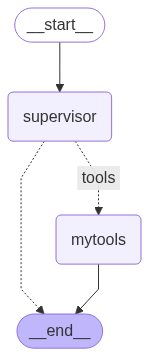

In [30]:
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
events = app.invoke({"messages": ["What is the GPD of the USA?"]})

Messages before invoking model: [HumanMessage(content='What is the GPD of the USA?', additional_kwargs={}, response_metadata={}, id='f302b8de-c504-46f2-a731-54407df06576')]
Model response: content='' additional_kwargs={'tool_calls': [{'id': 'call_JWzNaOW2kpU5tyNa7Qrlbm0J', 'function': {'arguments': '{"query":"current GDP of the USA 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 88, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-C0q3sdFX2eawuaUBakVyF6RO7KBwc', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--b8d54ff0-01d6-419e-b980-d91eef5e1a20-0' tool_calls=[{'name': 'ta

In [37]:
events=app.stream(
    {"messages":["in which city the temp was 25 degree?"]},stream_mode="values"
    )

In [38]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

in which city the temp was 25 degree?
Messages before invoking model: [HumanMessage(content='in which city the temp was 25 degree?', additional_kwargs={}, response_metadata={}, id='948611a6-0755-4f8f-94a1-cfe22f99c2a6')]


Model response: content='The temperature of 25 degrees can occur in many cities around the world, depending on the time of year and local climate conditions. To provide an accurate answer, I would need to know the specific date or time frame you are interested in. Additionally, temperatures can vary throughout the day, so specifying whether you mean 25 degrees Celsius or Fahrenheit would also be helpful. If you have a specific date or location in mind, please let me know!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 89, 'total_tokens': 179, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C0q5ekDKF70KwzS2XMcxU0YnDTQ1T', 'service_tier': 'default', 'finish_reason': 'stop', 'log

In [33]:
for output in app.stream({"messages":["what is a weather in new delhi?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

Messages before invoking model: [HumanMessage(content='what is a weather in new delhi?', additional_kwargs={}, response_metadata={}, id='a8577c07-3899-4057-a5d5-a71cb31d9702')]
Model response: content='' additional_kwargs={'tool_calls': [{'id': 'call_6tuPU8yubcXoKWmI5HIdtwtc', 'function': {'arguments': '{"query":"current weather in New Delhi"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 88, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-C0q4isBeaCpEq7KNzwtGFk9VJGLqL', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--85ccabe7-40d1-449b-b0e8-755cff91f619-0' tool_calls=[{'name'